In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,  KFold
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix

In [2]:
df = pd.read_csv("/kaggle/input/dsn-hack-24/Train.csv")
test = pd.read_csv("/kaggle/input/dsn-hack-24/Test.csv")
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0


In [3]:
test['TENURE'].unique()

array(['K > 24 month', 'I 18-21 month', 'H 15-18 month', 'F 9-12 month',
       'E 6-9 month', 'G 12-15 month', 'J 21-24 month', 'D 3-6 month'],
      dtype=object)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         400000 non-null  object 
 1   REGION          242480 non-null  object 
 2   TENURE          400000 non-null  object 
 3   MONTANT         259723 non-null  float64
 4   FREQUENCE_RECH  259723 non-null  float64
 5   REVENUE         265337 non-null  float64
 6   ARPU_SEGMENT    265337 non-null  float64
 7   FREQUENCE       265337 non-null  float64
 8   DATA_VOLUME     203146 non-null  float64
 9   ON_NET          254181 non-null  float64
 10  ORANGE          233683 non-null  float64
 11  TIGO            160614 non-null  float64
 12  ZONE1           31690 non-null   float64
 13  ZONE2           25513 non-null   float64
 14  MRG             400000 non-null  object 
 15  REGULARITY      400000 non-null  int64  
 16  TOP_PACK        232671 non-null  object 
 17  FREQ_TOP_P

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTANT,259723.0,5522.971346,7099.640630,20.0,1000.0,3000.0,7300.0,226550.0
FREQUENCE_RECH,259723.0,11.503733,13.275514,1.0,2.0,6.0,15.0,133.0
REVENUE,265337.0,5505.487757,7175.802367,1.0,1000.0,3000.0,7340.0,233413.0
ARPU_SEGMENT,265337.0,1835.167658,2391.929290,0.0,333.0,1000.0,2447.0,77804.0
FREQUENCE,265337.0,13.951835,14.679943,1.0,3.0,9.0,19.0,91.0
DATA_VOLUME,203146.0,3369.763441,12281.867504,0.0,0.0,267.0,2925.0,934576.0
ON_NET,254181.0,275.917586,873.593034,0.0,5.0,27.0,155.0,45011.0
ORANGE,233683.0,95.532927,204.733272,0.0,7.0,29.0,99.0,6788.0
TIGO,160614.0,23.134608,63.061871,0.0,2.0,6.0,20.0,2758.0
ZONE1,31690.0,7.874282,35.642843,0.0,0.0,1.0,3.0,1657.0


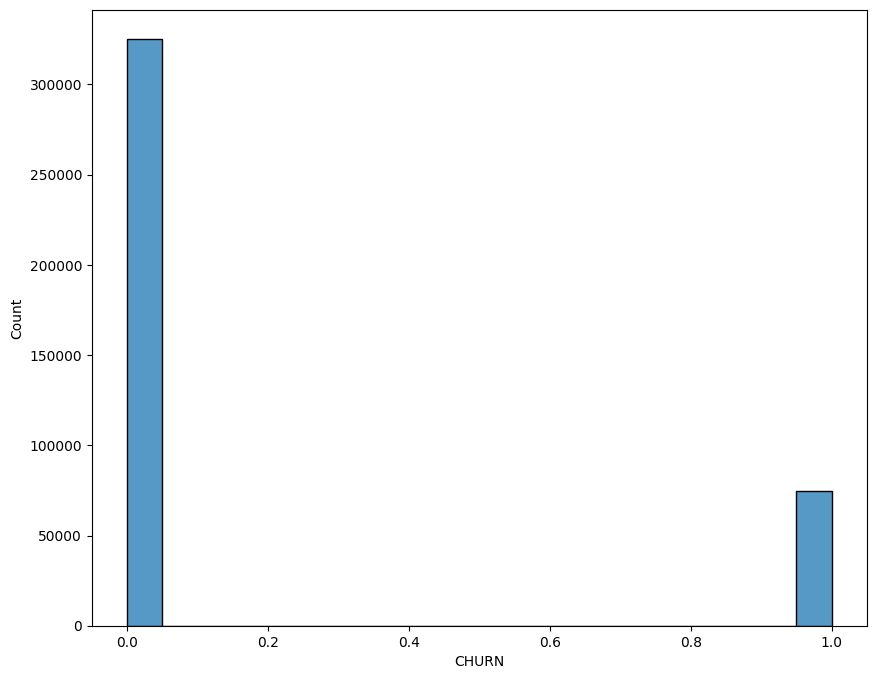

In [5]:
#distribution of the target
plt.figure(figsize=(10,8))
sns.histplot(df['CHURN'])
plt.show()

In [6]:
df.columns 

Index(['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK',
       'CHURN'],
      dtype='object')

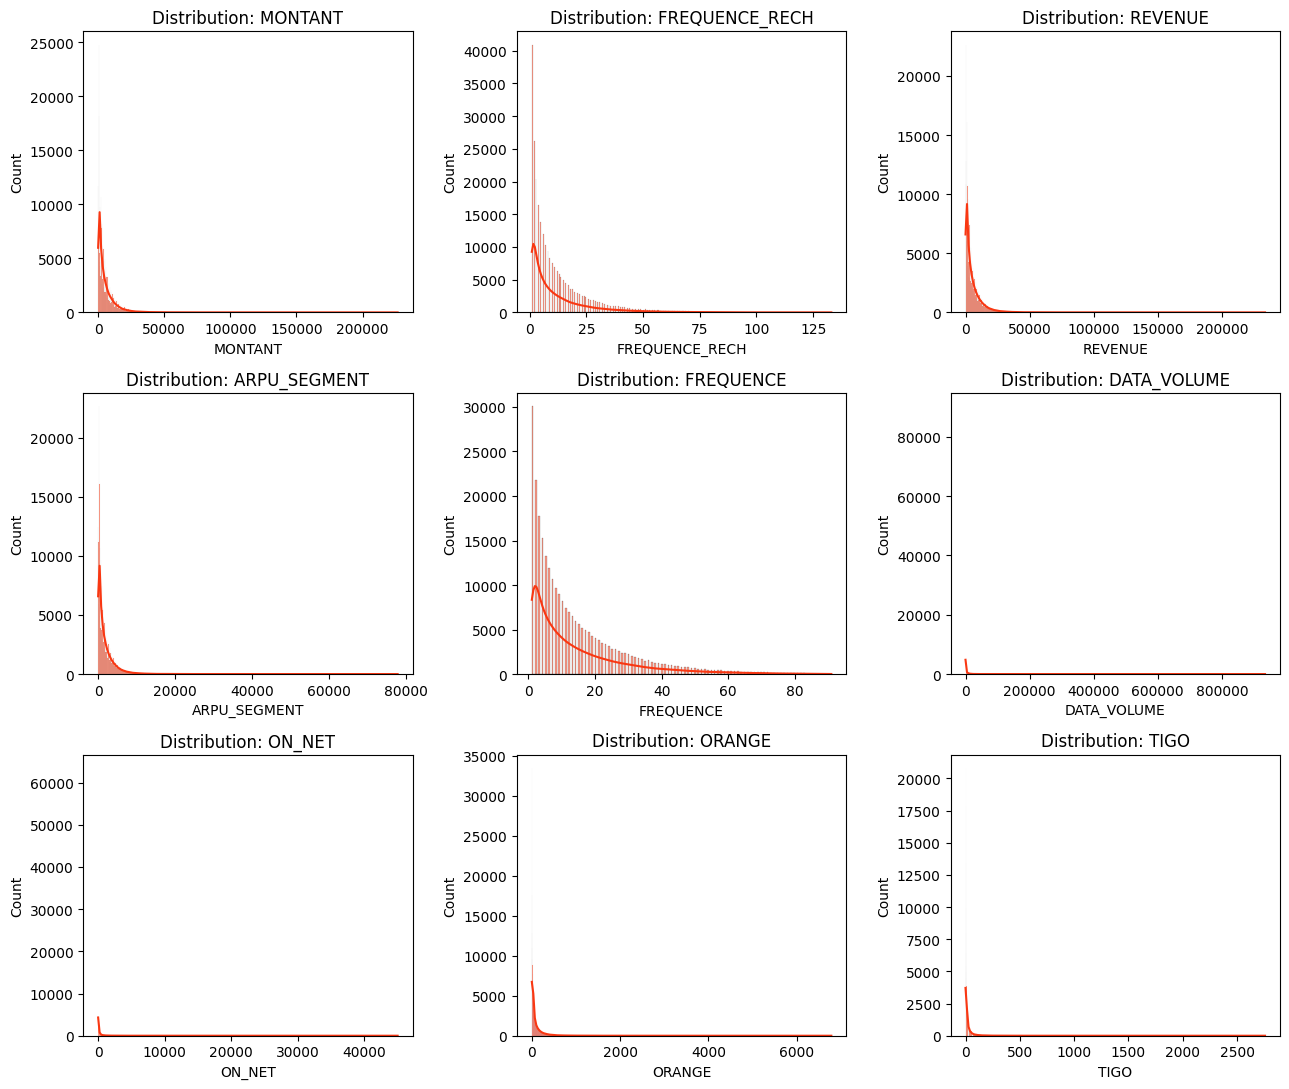

In [7]:
hue_color = '#F93712'

fig, axes = plt.subplots(3, 3, figsize=(13, 11))

sns.histplot(df['MONTANT'],kde=True,color=hue_color, ax=axes[0, 0])
axes[0, 0].set_xlabel('MONTANT')
axes[0, 0].set_title('Distribution: MONTANT')

sns.histplot(df['FREQUENCE_RECH'],kde=True,color=hue_color, ax=axes[0, 1])
axes[0, 1].set_xlabel('FREQUENCE_RECH')
axes[0, 1].set_title('Distribution: FREQUENCE_RECH')

sns.histplot(df['REVENUE'],kde=True,color=hue_color, ax=axes[0, 2])
axes[0, 2].set_xlabel('REVENUE')
axes[0, 2].set_title('Distribution: REVENUE')

sns.histplot(df['ARPU_SEGMENT'],kde=True,color=hue_color, ax=axes[1, 0])
axes[1, 0].set_xlabel('ARPU_SEGMENT')
axes[1, 0].set_title('Distribution: ARPU_SEGMENT')

sns.histplot(df['FREQUENCE'],kde=True,color=hue_color, ax=axes[1, 1])
axes[1, 1].set_xlabel('FREQUENCE')
axes[1, 1].set_title('Distribution: FREQUENCE')

sns.histplot(df['DATA_VOLUME'],kde=True,color=hue_color, ax=axes[1, 2])
axes[1, 2].set_xlabel('DATA_VOLUME')
axes[1, 2].set_title('Distribution: DATA_VOLUME')

sns.histplot(df['ON_NET'],kde=True,color=hue_color, ax=axes[2, 0])
axes[2, 0].set_xlabel('ON_NET')
axes[2, 0].set_title('Distribution: ON_NET')

sns.histplot(df['ORANGE'],kde=True,color=hue_color, ax=axes[2, 1])
axes[2, 1].set_xlabel('ORANGE')
axes[2, 1].set_title('Distribution: ORANGE')

sns.histplot(df['TIGO'],kde=True,color=hue_color, ax=axes[2, 2])
axes[2, 2].set_xlabel('TIGO')
axes[2, 2].set_title('Distribution: TIGO')

plt.tight_layout()

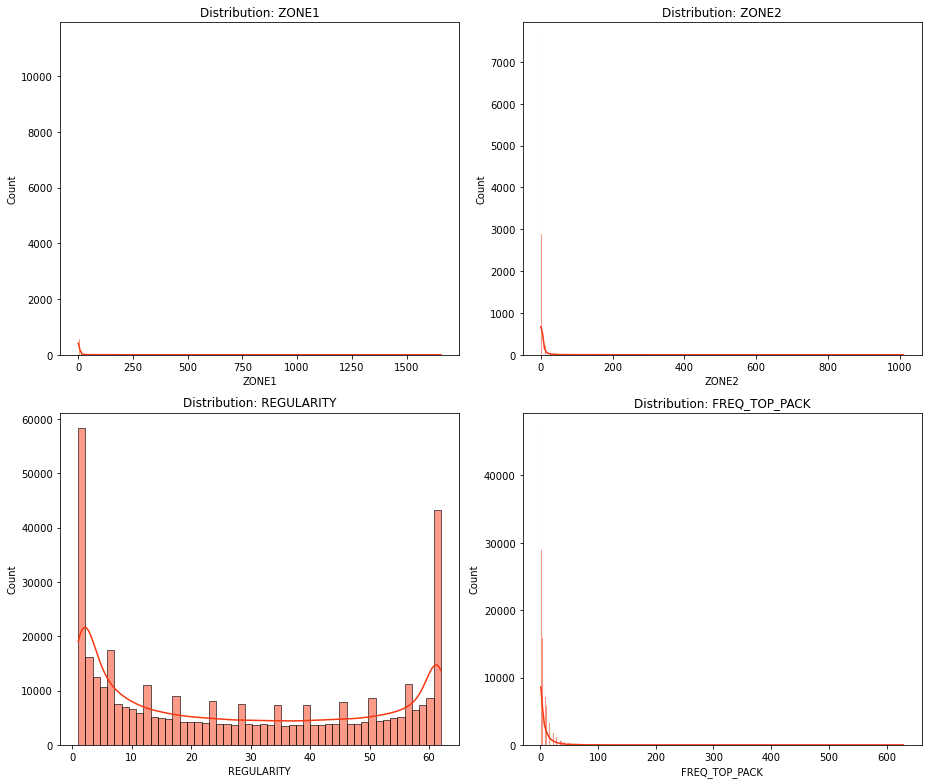

In [27]:
hue_color = '#F93712'

fig, axes = plt.subplots(2, 2, figsize=(13, 11))

sns.histplot(df['ZONE1'],kde=True,color=hue_color, ax=axes[0, 0])
axes[0, 0].set_xlabel('ZONE1')
axes[0, 0].set_title('Distribution: ZONE1')

sns.histplot(df['ZONE2'],kde=True,color=hue_color, ax=axes[0, 1])
axes[0, 1].set_xlabel('ZONE2')
axes[0, 1].set_title('Distribution: ZONE2')

sns.histplot(df['REGULARITY'],kde=True,color=hue_color, ax=axes[1, 0])
axes[1, 0].set_xlabel('REGULARITY')
axes[1, 0].set_title('Distribution: REGULARITY')

sns.histplot(df['FREQ_TOP_PACK'],kde=True,color=hue_color, ax=axes[1, 1])
axes[1, 1].set_xlabel('FREQ_TOP_PACK')
axes[1, 1].set_title('Distribution: FREQ_TOP_PACK')

plt.tight_layout()

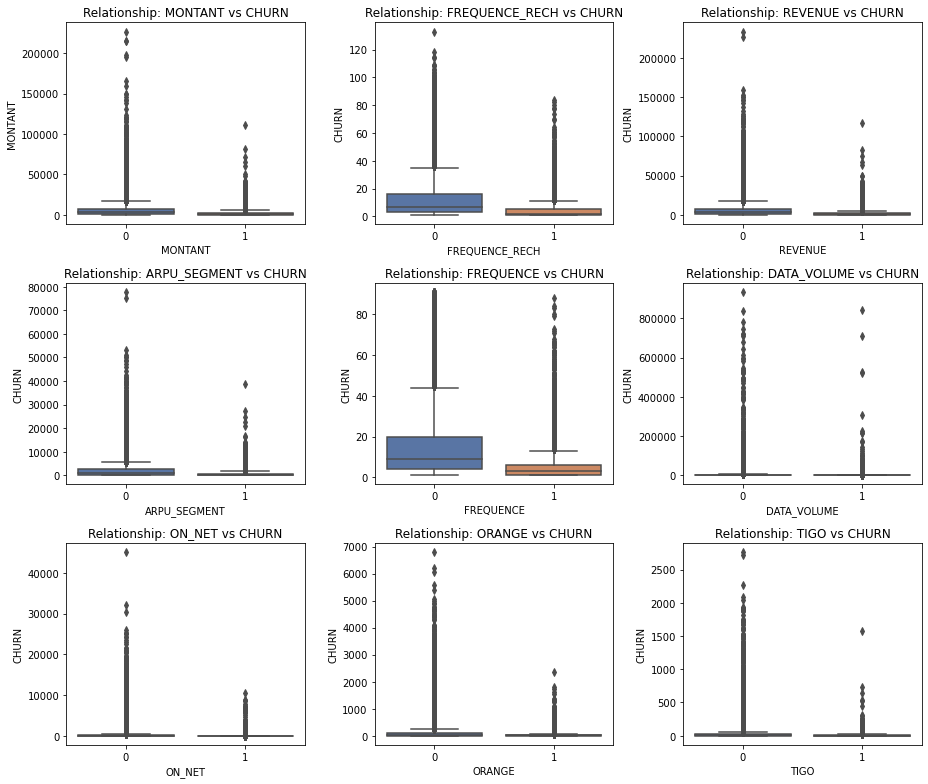

In [29]:
deep='deep'

fig, axes = plt.subplots(3, 3, figsize=(13, 11))

sns.boxplot(x = 'CHURN', y = 'MONTANT', data = df, palette=deep, ax=axes[0, 0])
axes[0, 0].set_xlabel('MONTANT')
axes[0, 2].set_ylabel('CHURN')
axes[0, 0].set_title('Relationship: MONTANT vs CHURN')

sns.boxplot(x = 'CHURN', y='FREQUENCE_RECH', data = df, palette=deep, ax=axes[0, 1])
axes[0, 1].set_xlabel('FREQUENCE_RECH')
axes[0, 1].set_ylabel('CHURN')
axes[0, 1].set_title('Relationship: FREQUENCE_RECH vs CHURN')

sns.boxplot(x = 'CHURN', y='REVENUE', data=df ,palette=deep, ax=axes[0, 2])
axes[0, 2].set_xlabel('REVENUE')
axes[0, 2].set_ylabel('CHURN')
axes[0, 2].set_title('Relationship: REVENUE vs CHURN')

sns.boxplot(x = 'CHURN',y='ARPU_SEGMENT', data=df, palette=deep, ax=axes[1, 0])
axes[1, 0].set_xlabel('ARPU_SEGMENT')
axes[1, 0].set_ylabel('CHURN')
axes[1, 0].set_title('Relationship: ARPU_SEGMENT vs CHURN')

sns.boxplot(x = 'CHURN', y='FREQUENCE', data= df, palette=deep, ax=axes[1, 1])
axes[1, 1].set_xlabel('FREQUENCE')
axes[1, 1].set_ylabel('CHURN')
axes[1, 1].set_title('Relationship: FREQUENCE vs CHURN')

sns.boxplot(x = 'CHURN', y='DATA_VOLUME', data=df, palette=deep, ax=axes[1, 2])
axes[1, 2].set_xlabel('DATA_VOLUME')
axes[1, 2].set_ylabel('CHURN')
axes[1, 2].set_title('Relationship: DATA_VOLUME vs CHURN')

sns.boxplot(x = 'CHURN', y='ON_NET', data=df, palette=deep, ax=axes[2, 0])
axes[2, 0].set_xlabel('ON_NET')
axes[2, 0].set_ylabel('CHURN')
axes[2, 0].set_title('Relationship: ON_NET vs CHURN')

sns.boxplot(x = 'CHURN', y='ORANGE', data=df, palette=deep, ax=axes[2, 1])
axes[2, 1].set_xlabel('ORANGE')
axes[2, 1].set_ylabel('CHURN')
axes[2, 1].set_title('Relationship: ORANGE vs CHURN')

sns.boxplot(x = 'CHURN', y='TIGO', data=df, palette=deep, ax=axes[2, 2])
axes[2, 2].set_xlabel('TIGO')
axes[2, 2].set_ylabel('CHURN')
axes[2, 2].set_title('Relationship: TIGO vs CHURN')

plt.tight_layout()

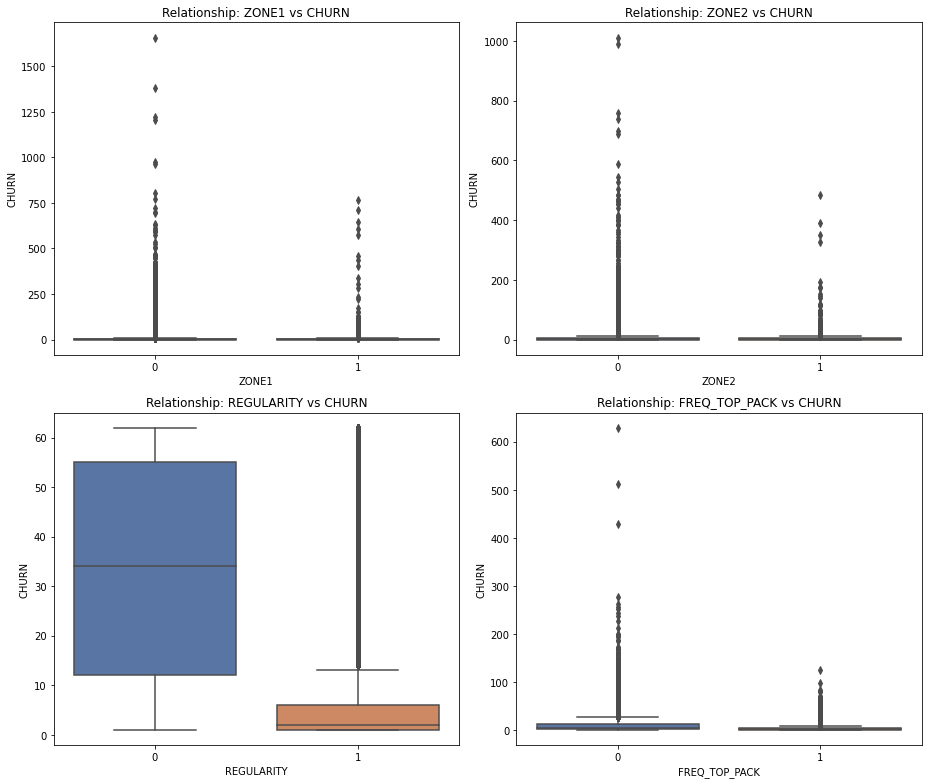

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(13, 11))

sns.boxplot(x = 'CHURN', y = 'ZONE1', data = df, palette=deep, ax=axes[0, 0])
axes[0, 0].set_xlabel('ZONE1')
axes[0, 0].set_ylabel('CHURN')
axes[0, 0].set_title('Relationship: ZONE1 vs CHURN')

sns.boxplot(x = 'CHURN', y='ZONE2', data = df, palette=deep, ax=axes[0, 1])
axes[0, 1].set_xlabel('ZONE2')
axes[0, 1].set_ylabel('CHURN')
axes[0, 1].set_title('Relationship: ZONE2 vs CHURN')

sns.boxplot(x = 'CHURN', y='REGULARITY', data=df ,palette=deep, ax=axes[1, 0])
axes[1, 0].set_xlabel('REGULARITY')
axes[1, 0].set_ylabel('CHURN')
axes[1, 0].set_title('Relationship: REGULARITY vs CHURN')

sns.boxplot(x = 'CHURN',y='FREQ_TOP_PACK', data=df, palette=deep, ax=axes[1, 1])
axes[1, 1].set_xlabel('FREQ_TOP_PACK')
axes[1, 1].set_ylabel('CHURN')
axes[1, 1].set_title('Relationship: FREQ_TOP_PACK vs CHURN')

plt.tight_layout()

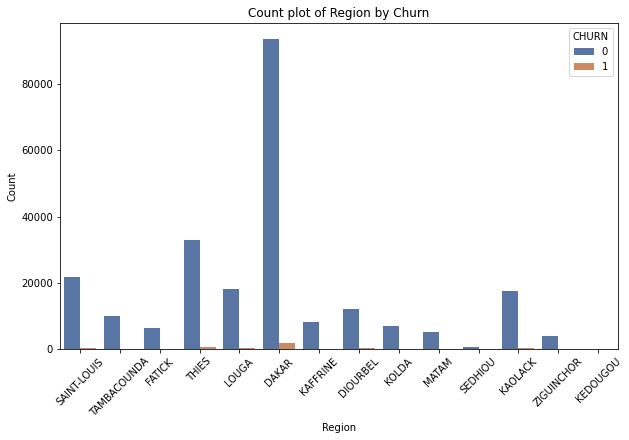

In [35]:
plt.figure(figsize=(10,6))
sns.countplot(x='REGION', hue='CHURN', data=df, palette=deep)
plt.title('Count plot of Region by Churn')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.show()

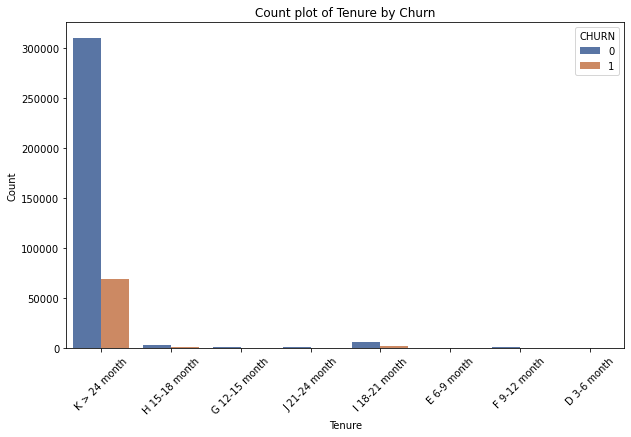

In [36]:
plt.figure(figsize=(10,6))
sns.countplot(x='TENURE', hue='CHURN', data=df, palette=deep)
plt.title('Count plot of Tenure by Churn')
plt.xlabel('Tenure')
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.show()

In [9]:
top_categories = df['TOP_PACK'].value_counts().nlargest(10).index
filtered = df[df['TOP_PACK'].isin(top_categories)]

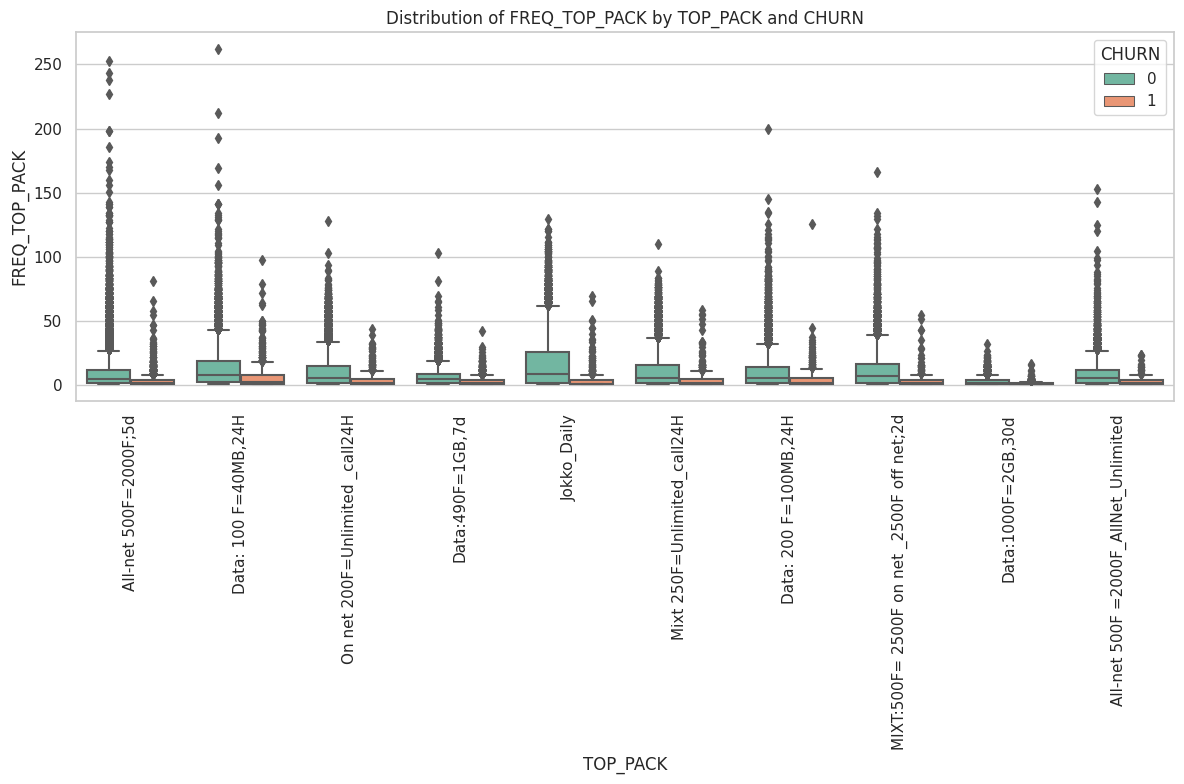

In [11]:
# Set the aesthetics of the plots
sns.set(style="whitegrid")
# Create the plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='TOP_PACK', y='FREQ_TOP_PACK', hue='CHURN', data=filtered, palette='Set2')

# Rotate x labels for better readability
plt.xticks(rotation=90)

# Add title and labels
plt.title('Distribution of FREQ_TOP_PACK by TOP_PACK and CHURN')
plt.xlabel('TOP_PACK')
plt.ylabel('FREQ_TOP_PACK')

# Show plot
plt.tight_layout()
plt.show()

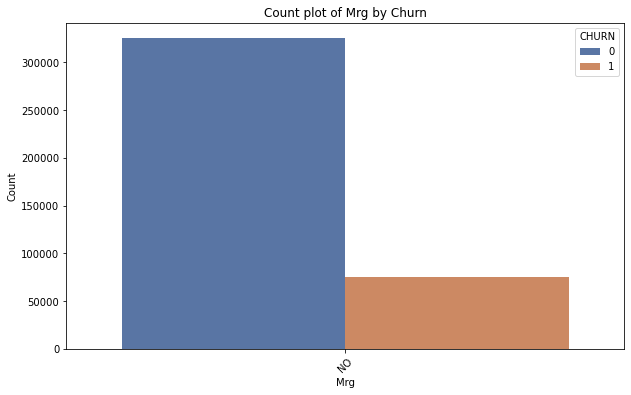

In [37]:
plt.figure(figsize=(10,6))
sns.countplot(x='MRG', hue='CHURN', data=df, palette=deep)
plt.title('Count plot of Mrg by Churn')
plt.xlabel('Mrg')
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.show()

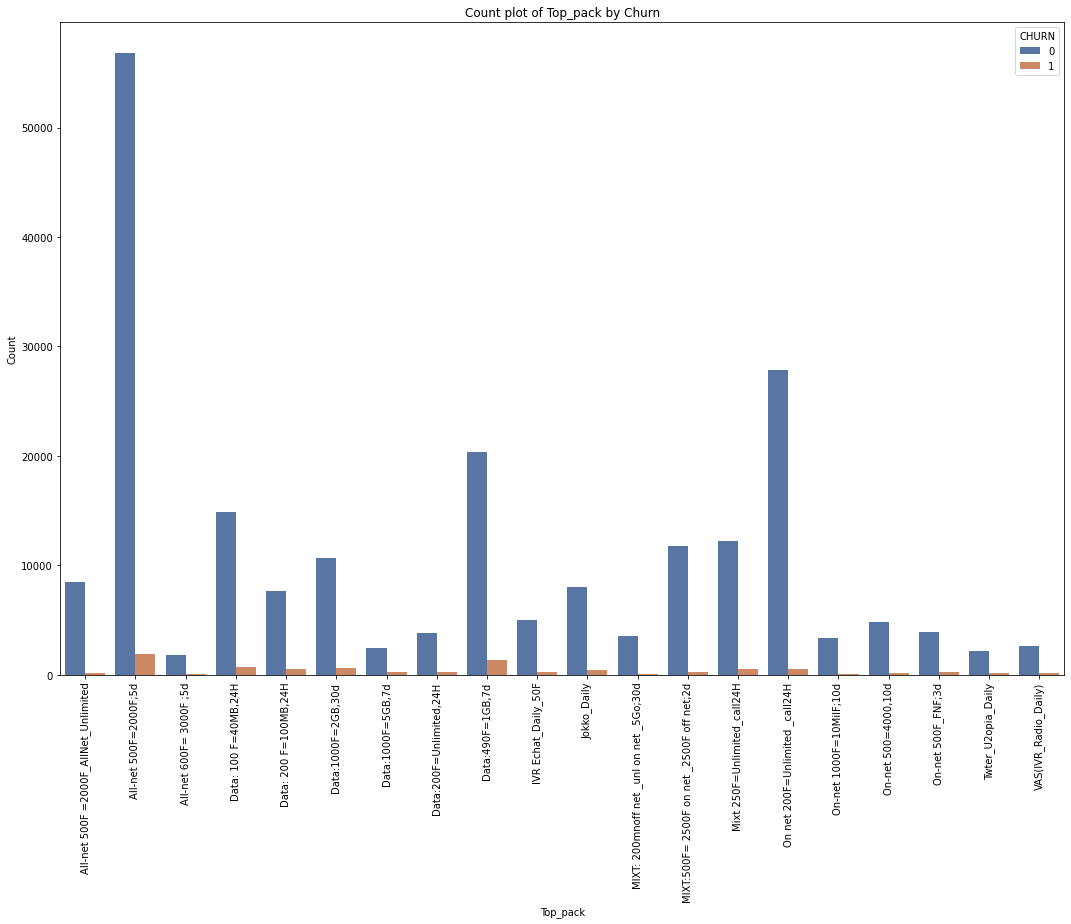

In [43]:
count_df = df.groupby(['TOP_PACK','CHURN']).size().reset_index(name='count')
total_counts = count_df.groupby('TOP_PACK')['count'].sum().reset_index(name='Total_count')
top_20_packs = total_counts.sort_values(by='Total_count', ascending=False).head(20)
top_20_packs_df = count_df[count_df['TOP_PACK'].isin(top_20_packs['TOP_PACK'])]

#=====================================================Plot figure=============================================================#

plt.figure(figsize=(18,12))
sns.barplot(x='TOP_PACK', y='count', hue='CHURN', data=top_20_packs_df, palette=deep)
plt.title('Count plot of Top_pack by Churn')
plt.xlabel('Top_pack')
plt.xticks(rotation=90)
plt.ylabel('Count')

plt.show()

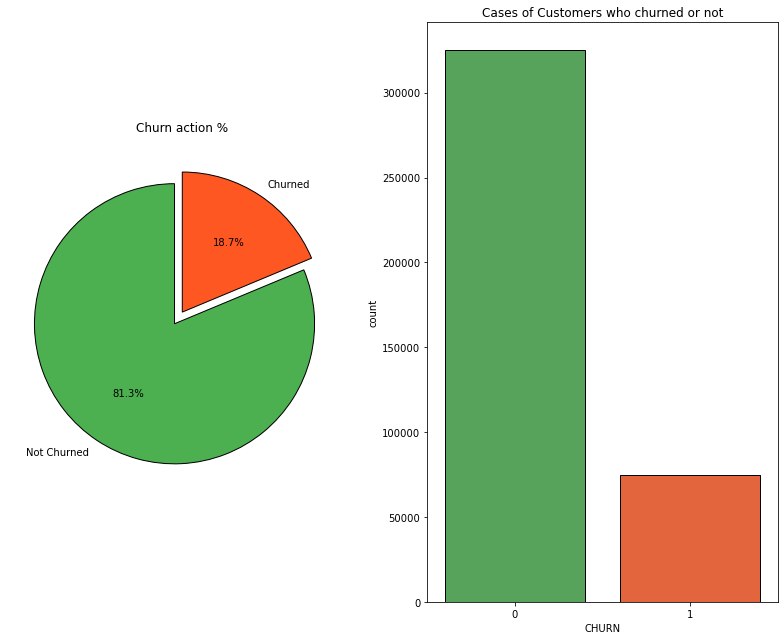

In [46]:
colours = ['#4CAF50', '#FF5722']

target_count = list(df['CHURN'].value_counts())
circle = [target_count[0]/sum(target_count) * 100,target_count[1]/sum(target_count) * 100]

fig, ax = plt.subplots(1,2,figsize=(11,9))
plt.subplot(1,2,1)

plt.pie(circle,labels=['Not Churned','Churned'],autopct='%1.1f%%',startangle=90,explode=(0.1,0),colors=colours,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Churn action %')

plt.subplot(1,2,2)
sns.countplot('CHURN',data = df,palette = colours,edgecolor = 'black')
plt.title('Cases of Customers who churned or not');
plt.tight_layout()
plt.show()


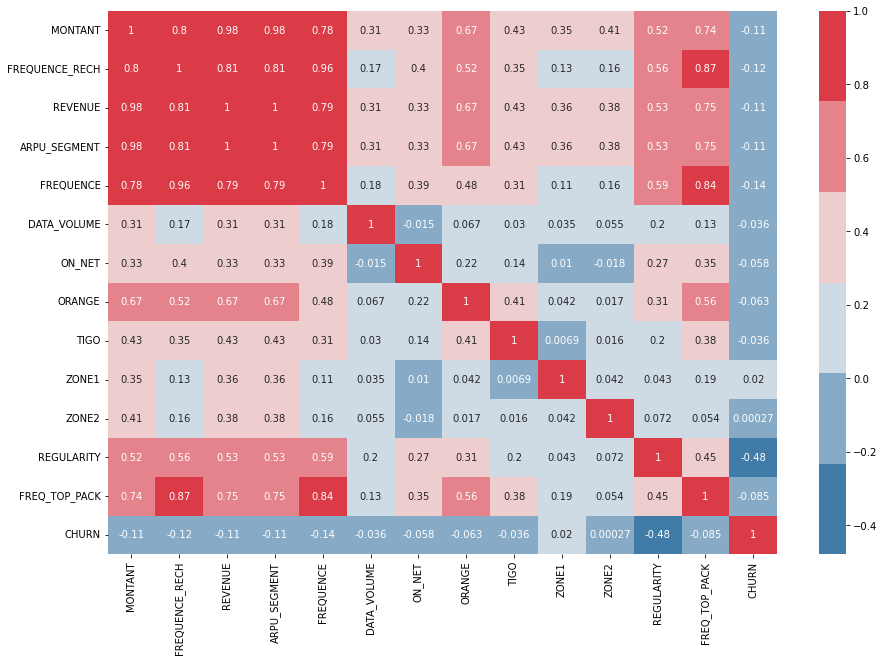

In [49]:
plt.figure(figsize=(15,10))
sns.heatmap(data = df.corr(),annot=True, cbar=True,cmap=sns.diverging_palette(240,10))
plt.show()

#### These are interesting results, some features exhibits strong correlation with each other, lets do some investigation....

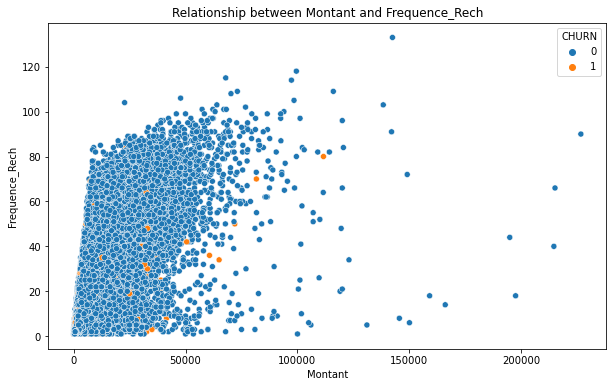

In [18]:
#scatter plots
plt.figure(figsize=(10,6))
sns.scatterplot(df['MONTANT'], df['FREQUENCE_RECH'],hue=df['CHURN'])
plt.xlabel('Montant')
plt.ylabel('Frequence_Rech')
plt.title('Relationship between Montant and Frequence_Rech')
plt.show()

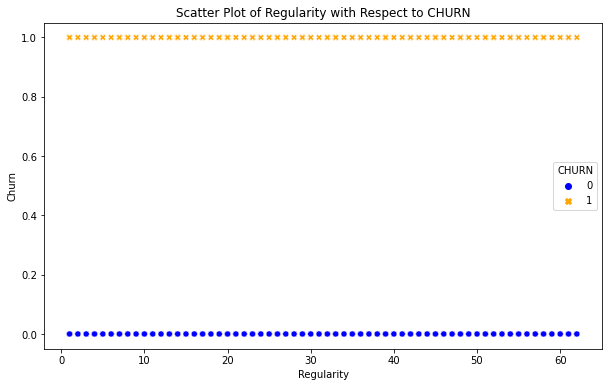

In [54]:
palette = {0: 'blue', 1: 'orange'}

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='REGULARITY', y='CHURN', hue='CHURN', data=df, palette=palette, style='CHURN')
plt.title('Scatter Plot of Regularity with Respect to CHURN')
plt.xlabel('Regularity')
plt.ylabel('Churn')
plt.show()

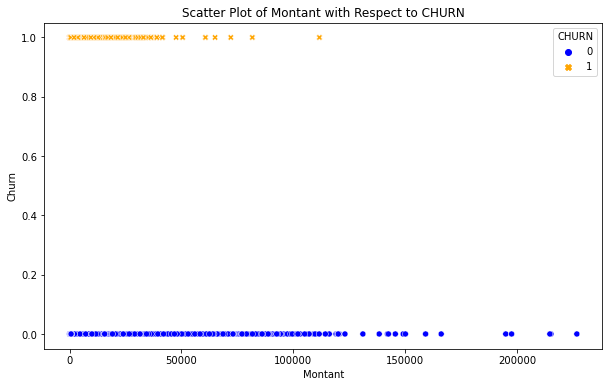

In [43]:
palette = {0: 'blue', 1: 'orange'}

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MONTANT', y='CHURN', hue='CHURN', data=df, palette=palette, style='CHURN')
plt.title('Scatter Plot of Montant with Respect to CHURN')
plt.xlabel('Montant')
plt.ylabel('Churn')
plt.show()

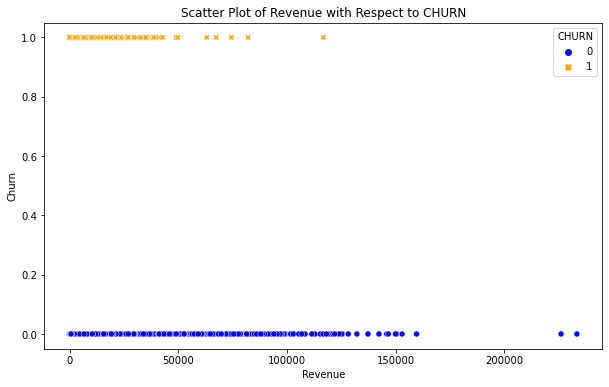

In [44]:
palette = {0: 'blue', 1: 'orange'}

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='REVENUE', y='CHURN', hue='CHURN', data=df, palette=palette, style='CHURN')
plt.title('Scatter Plot of Revenue with Respect to CHURN')
plt.xlabel('Revenue')
plt.ylabel('Churn')
plt.show()

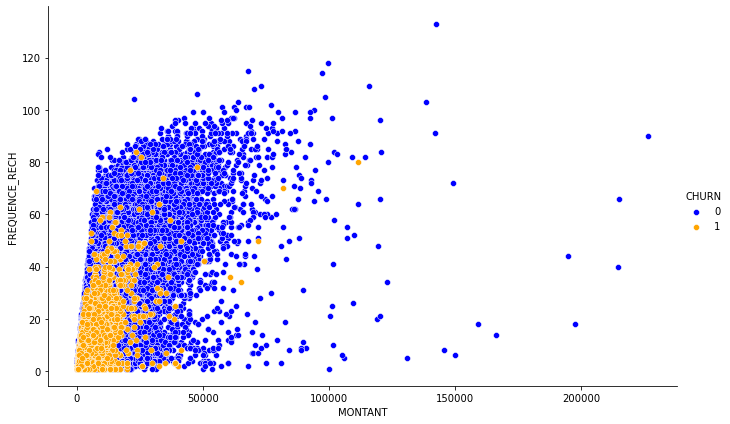

In [35]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'MONTANT', 'FREQUENCE_RECH')
g.add_legend()
plt.show()

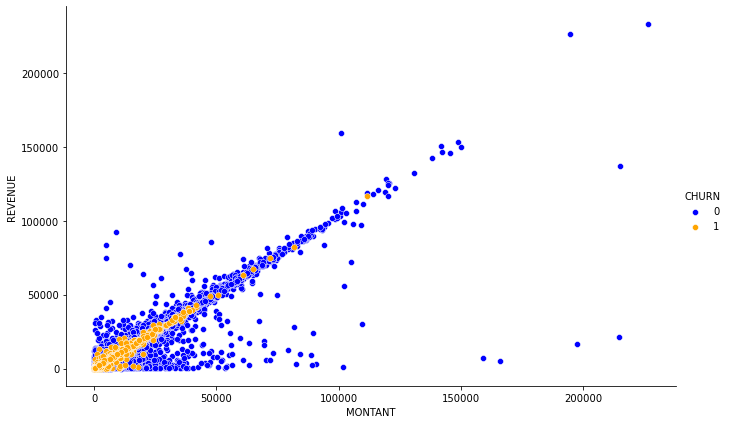

In [36]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'MONTANT', 'REVENUE')
g.add_legend()
plt.show()

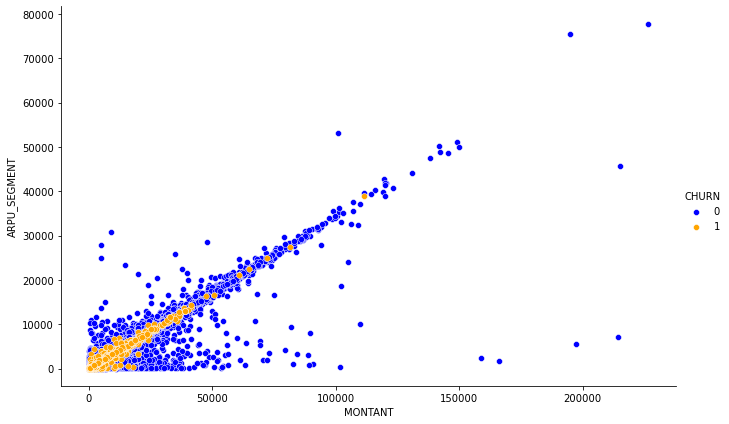

In [38]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'MONTANT', 'ARPU_SEGMENT')
g.add_legend()
plt.show()

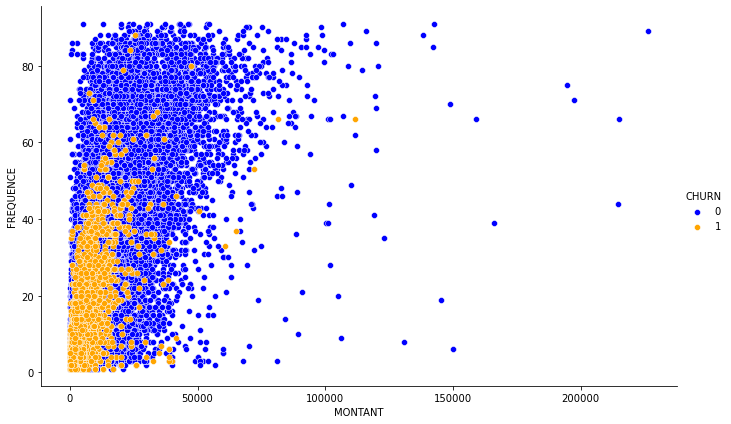

In [39]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'MONTANT', 'FREQUENCE')
g.add_legend()
plt.show()

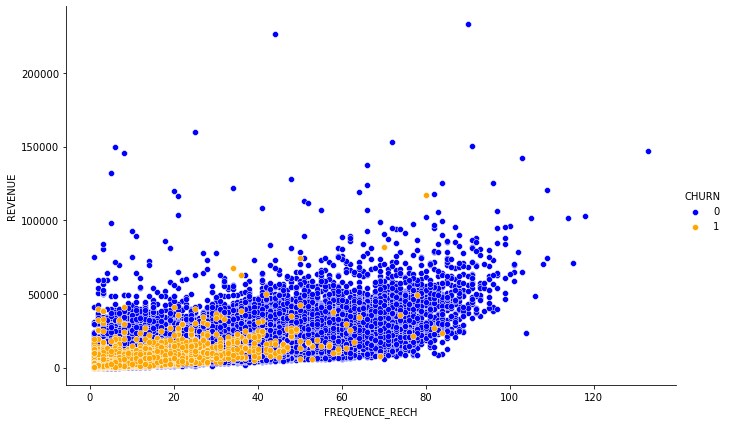

In [40]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'FREQUENCE_RECH', 'REVENUE')
g.add_legend()
plt.show()

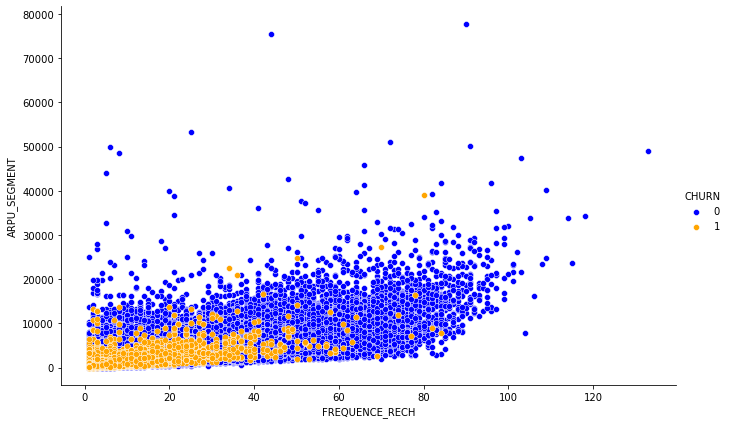

In [41]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'FREQUENCE_RECH', 'ARPU_SEGMENT')
g.add_legend()
plt.show()

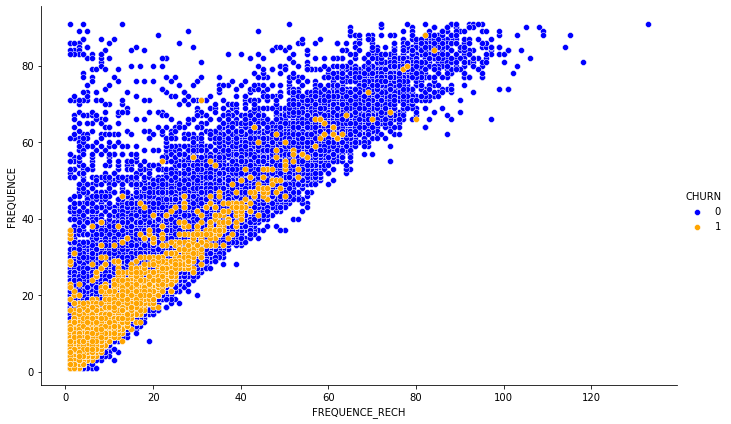

In [45]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'FREQUENCE_RECH', 'FREQUENCE')
g.add_legend()
plt.show()

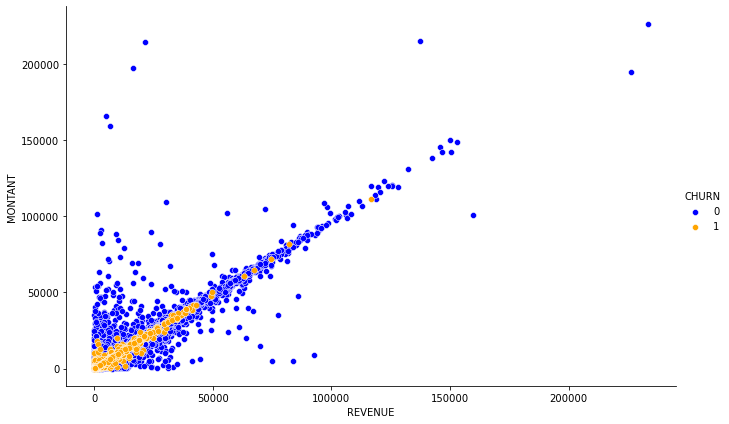

In [46]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'REVENUE', 'MONTANT')
g.add_legend()
plt.show()

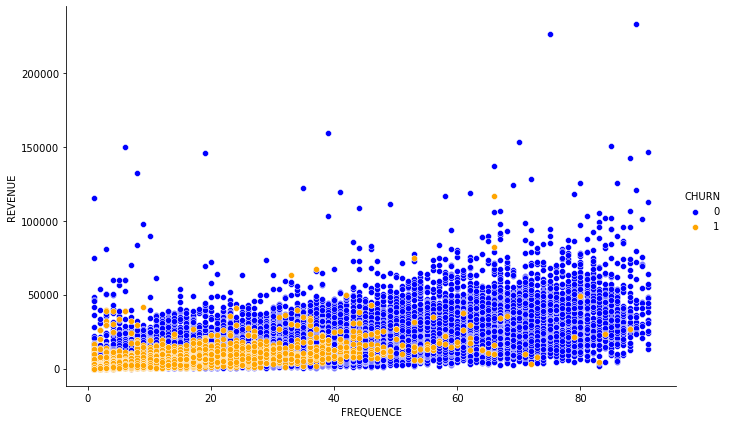

In [47]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'FREQUENCE', 'REVENUE')
g.add_legend()
plt.show()

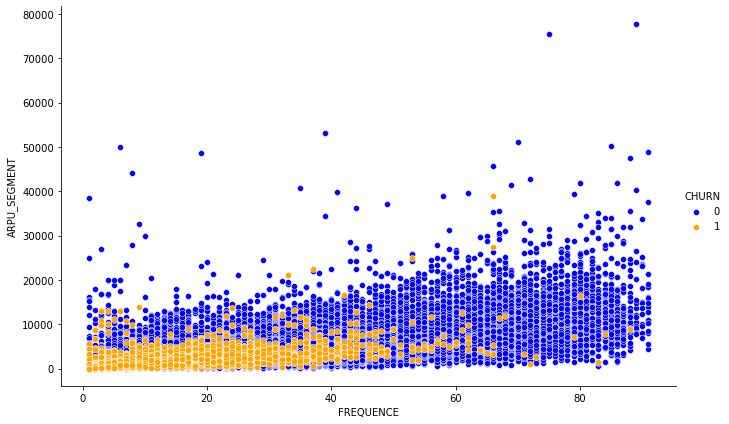

In [48]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'FREQUENCE', 'ARPU_SEGMENT')
g.add_legend()
plt.show()

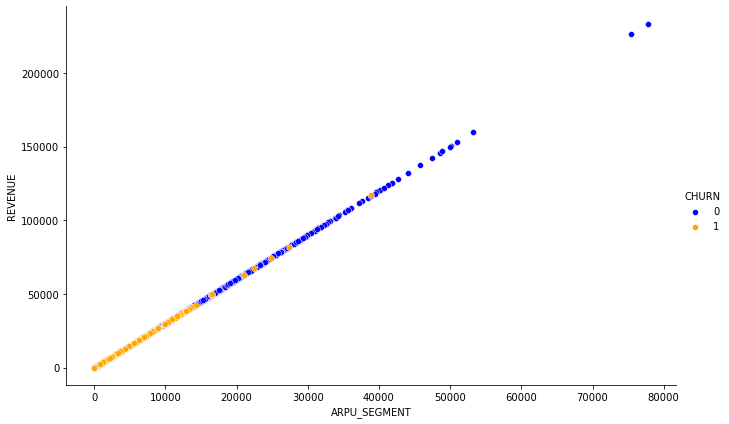

In [49]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'ARPU_SEGMENT', 'REVENUE')
g.add_legend()
plt.show()

#use pca

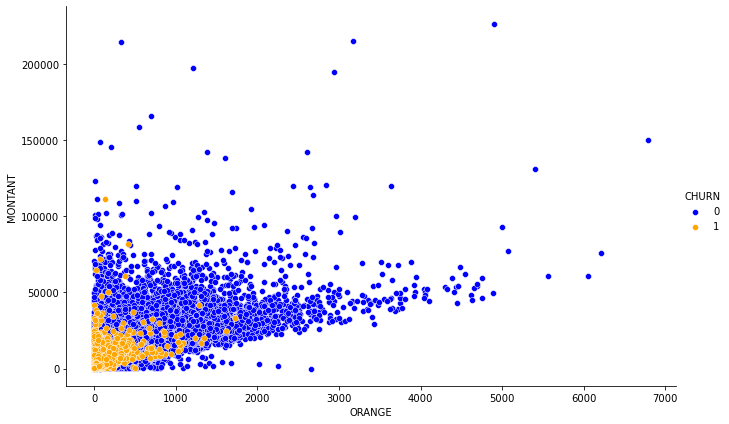

In [50]:
palette = {0: 'blue', 1: 'orange'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'ORANGE', 'MONTANT')
g.add_legend()
plt.show()

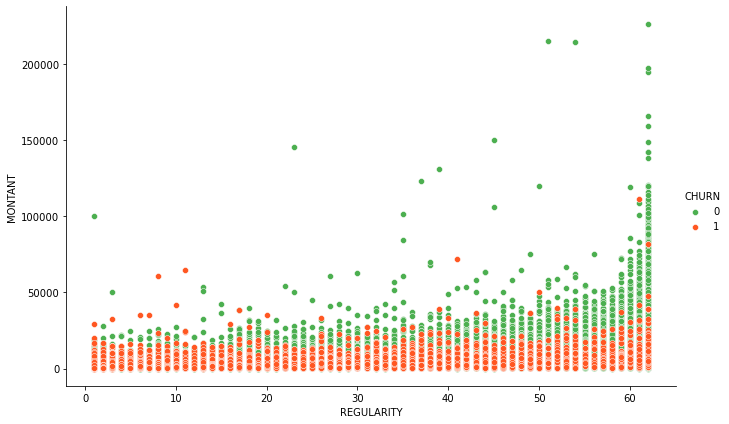

In [51]:
palette = {0: '#4CAF50', 1: '#FF5722'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'REGULARITY', 'MONTANT')
g.add_legend()
plt.show()

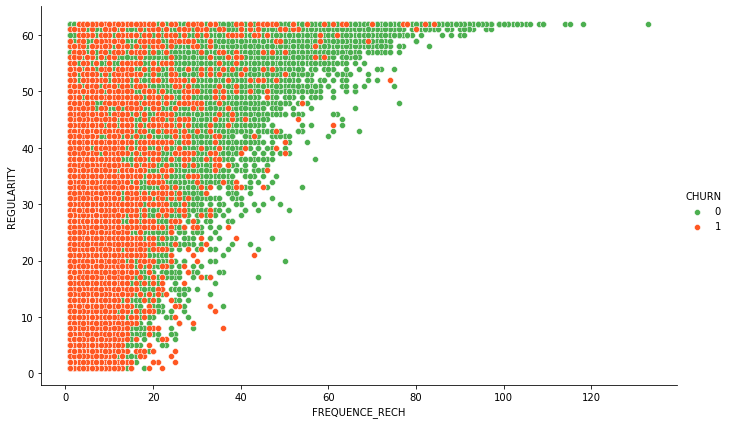

In [53]:
palette = {0: '#4CAF50', 1: '#FF5722'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'FREQUENCE_RECH', 'REGULARITY')
g.add_legend()
plt.show()

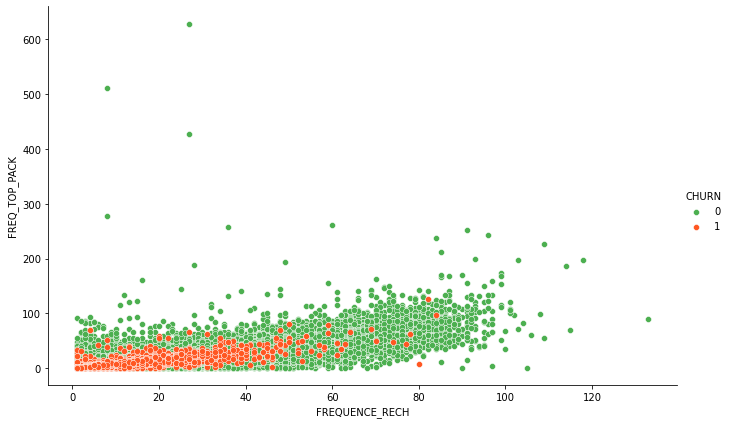

In [55]:
palette = {0: '#4CAF50', 1: '#FF5722'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'FREQUENCE_RECH', 'FREQ_TOP_PACK')
g.add_legend()
plt.show()

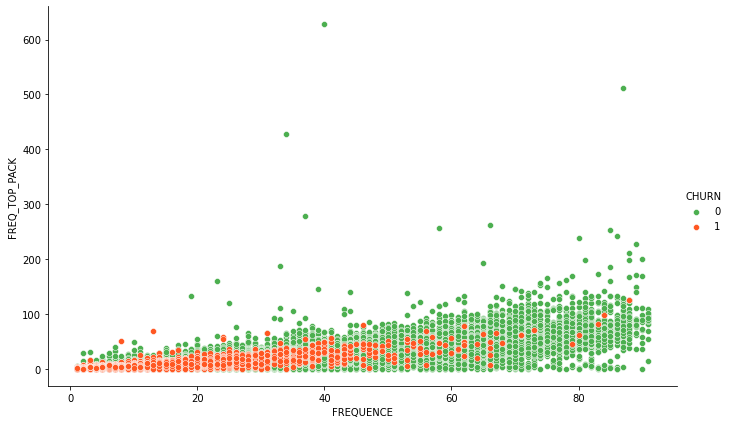

In [56]:
palette = {0: '#4CAF50', 1: '#FF5722'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'FREQUENCE', 'FREQ_TOP_PACK')
g.add_legend()
plt.show()

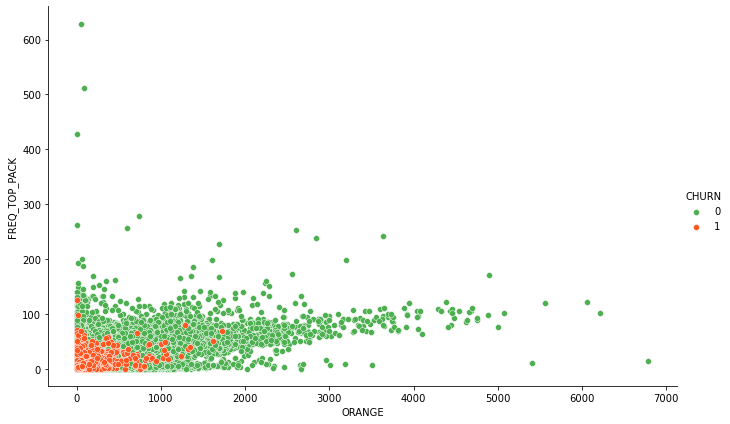

In [57]:
palette = {0: '#4CAF50', 1: '#FF5722'}
g = sns.FacetGrid(df, hue='CHURN', height=6,aspect=1.6, palette=palette)
g.map(sns.scatterplot, 'ORANGE', 'FREQ_TOP_PACK')
g.add_legend()
plt.show()

# **DATA PREPROCESSING**

In [158]:
df = pd.read_csv("/kaggle/input/dsn-hack-24/Train.csv")
test = pd.read_csv("/kaggle/input/dsn-hack-24/Test.csv")
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0


In [159]:
# Drop target variable
y = df['CHURN']
train_df = df.drop('CHURN', axis=1)

In [160]:
# Join train and test df for unified preprocessing
train_test = pd.concat([train_df,test], sort=False)
train_test.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN


In [161]:
missing_values = train_test.isnull().sum()
missing_values

user_id                0
REGION            196813
TENURE                 0
MONTANT           175228
FREQUENCE_RECH    175228
REVENUE           168153
ARPU_SEGMENT      168153
FREQUENCE         168153
DATA_VOLUME       246192
ON_NET            182202
ORANGE            207517
TIGO              299174
ZONE1             460630
ZONE2             468065
MRG                    0
REGULARITY             0
TOP_PACK          209032
FREQ_TOP_PACK     209032
dtype: int64

In [162]:
missing_percentage = (missing_values/len(train_test)) * 100
missing_data_df = pd.DataFrame({'missing_values': missing_values,'Percentage %': missing_percentage})
missing_data_df = missing_data_df[missing_data_df['missing_values']>0].sort_values(by='Percentage %', ascending=False)
missing_data_df

,missing_values,Percentage %
ZONE2,468065,93.6130
ZONE1,460630,92.1260
TIGO,299174,59.8348
DATA_VOLUME,246192,49.2384
TOP_PACK,209032,41.8064
FREQ_TOP_PACK,209032,41.8064
ORANGE,207517,41.5034
REGION,196813,39.3626
ON_NET,182202,36.4404
MONTANT,175228,35.0456


In [163]:
# Drop columns that contain more than 50% missing values
train_test = train_test.drop(['ZONE2','ZONE1','TIGO'], axis=1)
train_test.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,NO,62,All-net 500F=2000F;5d,35.0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,NO,40,"Data: 100 F=40MB,24H",22.0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NO,32,All-net 500F=2000F;5d,3.0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,NO,18,On net 200F=Unlimited _call24H,3.0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NO,50,NaN,NaN


In [164]:
#Fill the missing data in the region column with "NO_REGION"
# Fill the missing data in the top_pack column with "No_pack"
train_test['REGION'].fillna('NO_REGION', inplace=True)
train_test['TOP_PACK'].fillna('No_pack', inplace=True)

In [54]:
# Fill missing values in numerical columns with the median or -99999 at random
'''def fill_median_or_randomNum(column):
    median_value = column.median()
    #create a mask where NaNs are located
    nan_mask = column.isna()
    #Random choice between median and -99999 for nan values
    choices = np.random.choice([median_value,-99999], size=nan_mask.sum(), p=[0.5,0.5])
    #fill the NaNs with the selected values
    column.loc[nan_mask] = choices
    
    return column

#Apply the function to each numeric column in the data
for column in train_test.select_dtypes(include=[np.number]).columns:
    train_test[column] = fill_median_or_randomNum(train_test[column])'''

In [165]:
#fill with -99999 or any high neg_value to distinguish between actual datapoints and missing values
fill_99999 = ['MONTANT','FREQUENCE_RECH','REVENUE','ARPU_SEGMENT','FREQUENCE',
                'DATA_VOLUME','ON_NET','ORANGE','FREQ_TOP_PACK']

for col in fill_99999:
    train_test[col].fillna(-99999, inplace=True)

In [69]:
# Fill missing values in numerical columns with the median
#for col in train_test.select_dtypes(include=[np.number]).columns:
 #   train_test[col].fillna(train_test[col].median(), inplace=True)

In [166]:
train_test.isnull().sum()

user_id           0
REGION            0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
MRG               0
REGULARITY        0
TOP_PACK          0
FREQ_TOP_PACK     0
dtype: int64

In [167]:
# A function to encode the Tenure based on the least amount of month spent
def Tenure(x):
    if x == 'K > 24 month':
        return 24
    elif x == 'H 15-18 month':
        return 15
    elif x == 'G 12-15 month':
        return 12
    elif x == 'J 21-24 month':
        return 21
    elif x == 'I 18-21 month':
        return 18
    elif x == 'E 6-9 month':
        return 6
    elif x == 'F 9-12 month':
        return 9
    elif x == 'D 3-6 month':
        return 3
    else:
        pass

train_test['TENURE'] = train_test['TENURE'].apply(Tenure)
train_test.head(3)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,24,17000.0,32.0,18000.0,6000.0,34.0,-99999.0,97.0,355.0,NO,62,All-net 500F=2000F;5d,35.0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NO_REGION,24,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,NO,40,"Data: 100 F=40MB,24H",22.0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,24,1500.0,3.0,1500.0,500.0,3.0,-99999.0,30.0,30.0,NO,32,All-net 500F=2000F;5d,3.0


# **BASELINE MODEL - CATBOOST**

In [ ]:
#Encode categorical variable
categories = ['REGION','TOP_PACK']
train_test = pd.get_dummies(train_test, columns = categories, drop_first=True) 


* drop_first=True which drops the the first dummy feature category in Region and Top pack.
* This helps to avoid redundancy in the data.
* Redundancy causes multicollinearity

In [ ]:
# Split the combined data back into train and test data
train = train_test.iloc[:len(y), :]
test = train_test.iloc[len(y):, :]
print('Train Shape: ',train.shape, end='\n\n')
print('Test Shape: ',test.shape, end='\n\n')

In [ ]:
#Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=15)

In [ ]:
# Initializing and training the CatBoostClassifier
Base_Model = CatBoostClassifier(n_estimators=10000, max_depth=10,loss_function='Logloss',
                                reg_lambda = 370,use_best_model=True, eval_metric='Logloss')
Base_Model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=False)

In [ ]:
y_pred = Base_Model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred)

In [ ]:
# Predicting probabilities for log loss calculation
y_pred_proba = Base_Model.predict_proba(X_val)[:, 1]
print("Log Loss:", log_loss(y_val, y_pred_proba))

In [ ]:
# Confusion matrix
confusion = confusion_matrix(y_val, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Further Preprocessing and Feature Engineering**

In [168]:
#========================================Features Engineering=====================================================#

train_test['REVENUE-MONTANT'] = train_test['REVENUE'] - train_test['MONTANT']
train_test['REVENUE/MONTANT'] = train_test['REVENUE'] / train_test['MONTANT']
train_test['active_per_duration'] = train_test['TENURE'] / train_test['REGULARITY']
train_test['tenure_to_topup_frequency'] = train_test['TENURE'] / train_test['FREQUENCE_RECH']
train_test['income_in90days_perRevenue'] = train_test['ARPU_SEGMENT'] / train_test['REVENUE'] 
train_test['net/reg'] = train_test['ON_NET'] / train_test['REGULARITY']
train_test['data/reg'] = train_test['DATA_VOLUME'] / train_test['REGULARITY']

#=====================================Log transformation of highly skewed features========================#

train_test['reg_log'] = np.log1p(train_test['REGULARITY'] + 1e-9)
train_test['rech_log'] = np.log1p(train_test['FREQUENCE_RECH'] + 1e-9)
train_test['data_log'] = np.log1p(train_test['DATA_VOLUME'] + 1e-9)
train_test['montant_log'] = np.log1p(train_test['MONTANT'] + 1e-9)
train_test['rev_log'] = np.log1p(train_test['REVENUE'] + 1e-9)
train_test['freq_log'] = np.log1p(train_test['FREQUENCE'] + 1e-9)
train_test['orange_log'] = np.log1p(train_test['ORANGE'] + 1e-9)
train_test['reglog-datalog'] = train_test['reg_log'] - train_test['data_log']
train_test['reglog-montlog'] = train_test['reg_log'] - train_test['montant_log']

     

In [169]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#====================================================================================================================#

# Define the set of correlated features
correlated_features = [
    'MONTANT', 'FREQUENCE_RECH', 'REVENUE', 
    'ARPU_SEGMENT', 'FREQUENCE', 'FREQ_TOP_PACK'
]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_test[correlated_features])

# Apply PCA to the set of correlated features
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create new features from the principal components
train_test['PCA_1'] = principal_components[:, 0]
train_test['PCA_2'] = principal_components[:, 1]

#==================================================================================================================#
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by components: {explained_variance}")

#train_test.head(2)


Explained variance by components: [0.93269066 0.0380555 ]


In [170]:
train_test.head(3)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,...,rech_log,data_log,montant_log,rev_log,freq_log,orange_log,reglog-datalog,reglog-montlog,PCA_1,PCA_2
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,24,17000.0,32.0,18000.0,6000.0,34.0,-99999.0,97.0,...,3.496508,NaN,9.741027,9.798183,3.555348,5.874931,NaN,-5.597893,2.042153,-0.090222
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NO_REGION,24,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,...,3.401197,7.475906,8.366603,8.395703,3.637586,1.386294,-3.762334,-4.653031,1.787592,-0.173681
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,24,1500.0,3.0,1500.0,500.0,3.0,-99999.0,30.0,...,1.386294,NaN,7.313887,7.313887,1.386294,3.433987,NaN,-3.817379,1.731549,-0.191497


In [171]:
#Drop user_id and MRG(which contains a single category which won't be useful for the model)
train_test = train_test.drop(['user_id','MRG'], axis=1)
train_test.head(2)

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,...,rech_log,data_log,montant_log,rev_log,freq_log,orange_log,reglog-datalog,reglog-montlog,PCA_1,PCA_2
0,SAINT-LOUIS,24,17000.0,32.0,18000.0,6000.0,34.0,-99999.0,97.0,355.0,...,3.496508,NaN,9.741027,9.798183,3.555348,5.874931,NaN,-5.597893,2.042153,-0.090222
1,NO_REGION,24,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,...,3.401197,7.475906,8.366603,8.395703,3.637586,1.386294,-3.762334,-4.653031,1.787592,-0.173681


In [172]:
#convert the Tenure feature to int
train_test['TENURE'].astype('int64')
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   REGION                      500000 non-null  object 
 1   TENURE                      500000 non-null  int64  
 2   MONTANT                     500000 non-null  float64
 3   FREQUENCE_RECH              500000 non-null  float64
 4   REVENUE                     500000 non-null  float64
 5   ARPU_SEGMENT                500000 non-null  float64
 6   FREQUENCE                   500000 non-null  float64
 7   DATA_VOLUME                 500000 non-null  float64
 8   ON_NET                      500000 non-null  float64
 9   ORANGE                      500000 non-null  float64
 10  REGULARITY                  500000 non-null  int64  
 11  TOP_PACK                    500000 non-null  object 
 12  FREQ_TOP_PACK               500000 non-null  float64
 13  REVENUE-MONTANT     

In [173]:
#The function below systematically checks each TOP_PACK value against different sets of keywords and 
#categorizes the values into predefined categories ('call', 'VAS', 'data', 'international', 'social media', 'others').
#If a value matches any of the conditions, it gets replaced by the corresponding category.

#=======================================================================================================================#
# List of keywords related to voice call packages in the 'TOP_PACK' feature
call = [
    'all-net', 'on net', 'on-net', 'crbt', 'cvm', 'postpaid', 'unlimited', 
    'grps', 'incoming', 'mixt', 'gprs', 'ymgx', 'fnf', 'chinguitel'
]

# List of keywords related to data packages in the 'TOP_PACK' feature
services = [
    'vas', 'ivr', 'pilot', 'APANews', 'jokko_promo', 'jokko', 'fifa_ts_daily',
    'yakalma', 'mromo', 'supermagik', 'evc'
]

# List of other miscellaneous keywords that do not fit into the 'call' or 'services' categories
others = [
    'yewouleen', 'yakalma', 'liberte', '301765007', '305155009', 
    'staff_cpe_rent', '10mnonnet'
]

#========================================Top_Pack Feature Extraction==========================================#
def Top_pack_Feature_Extraction(train_test):
    # Categorize 'TOP_PACK' based on keywords related to calls
    train_test['TOP_PACK'] = np.where(
        train_test['TOP_PACK'].str.contains('|'.join(call), case=False, na=False, regex=True), 
        'call', 
        train_test['TOP_PACK']
    )
    
    # Categorize 'TOP_PACK' based on keywords related to services
    train_test['TOP_PACK'] = np.where(
        train_test['TOP_PACK'].str.contains('|'.join(services), case=False, na=False, regex=True), 
        'VAS', 
        train_test['TOP_PACK']
    )

    # Categorize 'TOP_PACK' as 'data' if it contains 'data' or 'wifi'
    train_test['TOP_PACK'] = np.where(
        train_test['TOP_PACK'].str.contains('data|wifi', case=False, na=False), 
        'data', 
        train_test['TOP_PACK']
    )

    # Categorize 'TOP_PACK' as 'international' if it contains 'internat'
    train_test['TOP_PACK'] = np.where(
        train_test['TOP_PACK'].str.contains('internat', case=False, na=False), 
        'international', 
        train_test['TOP_PACK']
    )

    # Categorize 'TOP_PACK' as 'social media' if it contains 'twter' or 'facebook'
    train_test['TOP_PACK'] = np.where(
        train_test['TOP_PACK'].str.contains('twter|facebook', case=False, na=False), 
        'social media', 
        train_test['TOP_PACK']
    )
    
    # Categorize 'TOP_PACK' based on other miscellaneous keywords
    train_test['TOP_PACK'] = np.where(
        train_test['TOP_PACK'].str.contains('|'.join(others), case=False, na=False, regex=True), 
        'others', 
        train_test['TOP_PACK']
    )
    return train_test



In [174]:
#======================================Apply Top_pack_Feature_Extraction========================================#
Top_pack_Feature_Extraction(train_test)

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,...,rech_log,data_log,montant_log,rev_log,freq_log,orange_log,reglog-datalog,reglog-montlog,PCA_1,PCA_2
0,SAINT-LOUIS,24,17000.0,32.0,18000.0,6000.0,34.0,-99999.0,97.0,355.0,...,3.496508,NaN,9.741027,9.798183,3.555348,5.874931e+00,NaN,-5.597893,2.042153,-0.090222
1,NO_REGION,24,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,...,3.401197,7.475906e+00,8.366603,8.395703,3.637586,1.386294e+00,-3.762334,-4.653031,1.787592,-0.173681
2,TAMBACOUNDA,24,1500.0,3.0,1500.0,500.0,3.0,-99999.0,30.0,30.0,...,1.386294,NaN,7.313887,7.313887,1.386294,3.433987e+00,NaN,-3.817379,1.731549,-0.191497
3,FATICK,24,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,...,1.386294,1.000000e-09,7.313887,7.823246,1.609438,3.828641e+00,2.944439,-4.369448,1.742683,-0.183613
4,FATICK,24,-99999.0,-99999.0,498.0,166.0,3.0,1.0,1.0,3.0,...,NaN,6.931472e-01,NaN,6.212606,1.386294,1.386294e+00,3.238678,NaN,-0.735634,1.835514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,LOUGA,24,200.0,1.0,20.0,7.0,1.0,-99999.0,-99999.0,0.0,...,0.693147,NaN,5.303305,3.044522,0.693147,1.000000e-09,NaN,-1.453157,0.930514,1.488404
99996,TAMBACOUNDA,24,1000.0,1.0,998.0,333.0,4.0,1.0,6.0,3.0,...,0.693147,6.931472e-01,6.908755,6.906755,1.609438,1.386294e+00,2.602690,-3.612918,0.947943,1.494670
99997,NO_REGION,18,1800.0,7.0,1799.0,600.0,9.0,81.0,2.0,0.0,...,2.079442,4.406719e+00,7.496097,7.495542,2.302585,1.000000e-09,-0.295845,-3.385223,1.737424,-0.189687
99998,THIES,24,2500.0,4.0,2515.0,838.0,4.0,-99999.0,43.0,106.0,...,1.609438,NaN,7.824446,7.830426,1.609438,4.672829e+00,NaN,-4.991233,1.751015,-0.185361


In [175]:
#Encode categorical variable

#=================================One Hot Encode the Region column======================================#
categories = ['REGION']
train_test = pd.get_dummies(train_test, columns = categories, drop_first=True)

#=================================Label Encode the Top pack column======================================#
encoder = LabelEncoder()
train_test['TOP_PACK_ENC'] = encoder.fit_transform(train_test['TOP_PACK'])
train_test.head(2)

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,REGULARITY,...,REGION_KOLDA,REGION_LOUGA,REGION_MATAM,REGION_NO_REGION,REGION_SAINT-LOUIS,REGION_SEDHIOU,REGION_TAMBACOUNDA,REGION_THIES,REGION_ZIGUINCHOR,TOP_PACK_ENC
0,24,17000.0,32.0,18000.0,6000.0,34.0,-99999.0,97.0,355.0,62,...,False,False,False,False,True,False,False,False,False,2
1,24,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,40,...,False,False,False,True,False,False,False,False,False,3


In [176]:
#Drop Top_pack feature
train_test = train_test.drop(['TOP_PACK'], axis=1)

In [177]:
# Split the combined data back into train and test data
Train = train_test.iloc[:len(y), :]
Test = train_test.iloc[len(y):, :]
print('Train Shape: ',Train.shape, end='\n\n')
print('Test Shape: ',Test.shape)

Train Shape:  (400000, 44)

Test Shape:  (100000, 44)


In [178]:
cluster_list = [
'REVENUE',
'MONTANT',
'FREQUENCE_RECH',
'FREQUENCE',
'ON_NET',
'ORANGE',
'REGULARITY',
'ARPU_SEGMENT',
'FREQ_TOP_PACK',
'REGION_NO_REGION']

In [179]:
from sklearn.cluster import KMeans

kmeans = KMeans(
        n_clusters=2, init='k-means++',
        n_init=20, max_iter=300,
        tol=1e-04, random_state=0
    )

In [180]:
%%capture 
#To avoid clumsy cell output

for col in cluster_list:
    if Train[col].dtype == object:
        dummies = pd.get_dummies(Train[col], drop_first=True)
        Test_dum = pd.get_dummies(Test[col], drop_first=True)
        kmeans.fit(dummies)
        Train[col+'_grouped'] = kmeans.labels_
        Test[col+'_grouped'] = kmeans.predict(Test_dum)
    else:
        kmeans.fit(pd.DataFrame(Train[col]))
        Train[col+'_grouped'] = kmeans.labels_
        Test[col+'_grouped'] = kmeans.predict(pd.DataFrame(Test[col]))

In [181]:
Train.shape, Test.shape

((400000, 54), (100000, 54))

In [182]:
Train=Train.fillna(0)
Test=Test.fillna(0)

In [183]:
sum(Train.isna().sum())

0

In [184]:
km = KMeans(
        n_clusters=2, init='k-means++',
        n_init=20, max_iter=300,
        tol=1e-04, random_state=10
    )

In [185]:
km.fit(Train)

KMeans(n_clusters=2, n_init=20, random_state=10)

In [186]:
Train['groups'] = km.labels_
Test['groups'] = km.predict(Test)

In [187]:
Train.shape, y.shape, Test.shape

((400000, 55), (400000,), (100000, 55))

The code above groups (cluster) the data in the Train and Test datasets into 2 clusters based on the features in the clust list. For categorical features, it first converts them to numeric format. After clustering, it adds new columns to indicate which cluster each data point belongs to. The final KMeans model is fitted to the entire Train dataset to determine overall clusters, and these clusters are assigned to both the Train and Test datasets.

In [188]:
#Explained variance by components PCA_1 and PCA_2: [0.93269066, 0.0380555 ]
# Drop the PCA_2 as the explained variance is very low
Train.drop(columns=['PCA_2'], inplace=True)
Test.drop(columns=['PCA_2'], inplace=True)

Train.head(2)

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,REGULARITY,...,MONTANT_grouped,FREQUENCE_RECH_grouped,FREQUENCE_grouped,ON_NET_grouped,ORANGE_grouped,REGULARITY_grouped,ARPU_SEGMENT_grouped,FREQ_TOP_PACK_grouped,REGION_NO_REGION_grouped,groups
0,24,17000.0,32.0,18000.0,6000.0,34.0,-99999.0,97.0,355.0,62,...,1,1,1,1,1,1,1,1,1,1
1,24,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,40,...,1,1,1,1,1,1,1,1,0,1


In [189]:
Test.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,REGULARITY,...,MONTANT_grouped,FREQUENCE_RECH_grouped,FREQUENCE_grouped,ON_NET_grouped,ORANGE_grouped,REGULARITY_grouped,ARPU_SEGMENT_grouped,FREQ_TOP_PACK_grouped,REGION_NO_REGION_grouped,groups
0,24,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,1,...,0,0,0,0,0,0,0,0,0,0
1,24,-99999.0,-99999.0,10.0,3.0,1.0,-99999.0,-99999.0,-99999.0,2,...,0,0,1,0,0,0,1,0,0,0
2,24,1900.0,15.0,2299.0,766.0,21.0,414.0,-99999.0,7.0,27,...,1,1,1,0,1,0,1,1,0,1
3,24,3000.0,9.0,2603.0,868.0,14.0,332.0,0.0,23.0,46,...,1,1,1,1,1,1,1,1,1,1
4,24,32000.0,47.0,33000.0,11000.0,47.0,-99999.0,128.0,555.0,61,...,1,1,1,1,1,1,1,1,1,1


In [190]:
#from sklearn.preprocessing import RobustScaler
#scaler = RobustScaler()
#Train_sc = scaler.fit_transform(Train)
#Test_sc = scaler.transform(Test)

In [191]:
#%%capture
#===========================================CatboostClassifier Algo================================================#
#===========================================K-Fold cross validation================================================#

cbt_error=[]
y_pred_cbt=[]
fold=KFold(n_splits=25)
i=1
for Train_index, Test_index in fold.split(Train,y):
    print(str(i) + ' iter')
    X_train, X_test = Train.iloc[Train_index], Train.iloc[Test_index]
    y_train, y_test = y.iloc[Train_index], y.iloc[Test_index]
    cbt_model = CatBoostClassifier(n_estimators=1000,eval_metric='Logloss',random_seed=10, use_best_model=True)
    cbt_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100)
    preds_cbt=cbt_model.predict_proba(X_test)[:,1]
    print("err: ",log_loss(y_test,preds_cbt))
    cbt_error.append((log_loss(y_test,preds_cbt)))
    cbt_pred = cbt_model.predict_proba(Test)[:,1]
    y_pred_cbt.append(cbt_pred)
    i+=1
np.mean(cbt_error)

1 iter
Learning rate set to 0.137797
0:	learn: 0.5062669	test: 0.5063164	test1: 0.5054979	best: 0.5054979 (0)	total: 97.2ms	remaining: 1m 37s
100:	learn: 0.2507139	test: 0.2507290	test1: 0.2476714	best: 0.2476714 (100)	total: 8.97s	remaining: 1m 19s
200:	learn: 0.2485210	test: 0.2485420	test1: 0.2475008	best: 0.2474416 (184)	total: 17.7s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2474415901
bestIteration = 184

Shrink model to first 185 iterations.
err:  0.24744159008188837
2 iter
Learning rate set to 0.137797
0:	learn: 0.5062711	test: 0.5062980	test1: 0.5055260	best: 0.5055260 (0)	total: 86.8ms	remaining: 1m 26s
100:	learn: 0.2505680	test: 0.2505906	test1: 0.2493375	best: 0.2493029 (85)	total: 8.64s	remaining: 1m 16s
200:	learn: 0.2483599	test: 0.2483813	test1: 0.2492659	best: 0.2491830 (151)	total: 16.8s	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2491830275
bestIteration = 151

Shrink model to firs

0.25202196850052866

In [192]:
sub_sample = pd.read_csv('/kaggle/input/dsn-hack-24/sample_submission.csv')

In [193]:
cat_sub = sub_sample.copy()
cat_sub.CHURN = np.mean(y_pred_cbt, axis=0)
cat_sub.head()

,user_id,CHURN
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,0.602333
1,5335efd940280b82143272275637d1e65d37eadb,0.741155
2,a581f4fa08677c26f83f643248c667e241043086,0.451098
3,64f67177d0775262b8087a9e2e3b8061b6324ae6,0.298246
4,0d6009a4594c4be22449b8d9cc01a0bcea98faea,0.233822


In [153]:
cat_sub.to_csv('catboost_submission13.csv', index=False)

In [154]:
#%%capture
#===========================================XGboostClassifier Algo================================================#
#===========================================K-Fold cross validation================================================#

xgb_error=[]
y_pred_xgb=[]
fold=KFold(n_splits=25)
i=1
for Train_index, Test_index in fold.split(Train,y):
    print(str(i) + ' iter')
    X_train, X_test = Train.iloc[Train_index], Train.iloc[Test_index]
    y_train, y_test = y.iloc[Train_index], y.iloc[Test_index]
    xgb_model = XGBClassifier(n_estimators=1000,eval_metric='logloss',random_seed= 10, use_best_model=True)
    xgb_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100)
    preds_xgb=xgb_model.predict_proba(X_test)[:,1]
    print("err: ",log_loss(y_test,preds_xgb))
    xgb_error.append((log_loss(y_test,preds_xgb)))
    xgb_pred = m2.predict_proba(Test)[:,1]
    y_pred_totcb2.append(xgb_pred)
    i+=1
np.mean(xgb_error)

1 iter
[0]	validation_0-logloss:0.38214	validation_1-logloss:0.38114
[100]	validation_0-logloss:0.24027	validation_1-logloss:0.24868
[127]	validation_0-logloss:0.23814	validation_1-logloss:0.24917
err:  0.24777760994238238
2 iter
[0]	validation_0-logloss:0.38209	validation_1-logloss:0.38217
[100]	validation_0-logloss:0.23996	validation_1-logloss:0.25175
[133]	validation_0-logloss:0.23707	validation_1-logloss:0.25215
err:  0.24964851209275224
3 iter
[0]	validation_0-logloss:0.38228	validation_1-logloss:0.37862
[100]	validation_0-logloss:0.24013	validation_1-logloss:0.24757
[154]	validation_0-logloss:0.23582	validation_1-logloss:0.24827
err:  0.24694612463733176
4 iter
[0]	validation_0-logloss:0.38184	validation_1-logloss:0.38661
[100]	validation_0-logloss:0.23988	validation_1-logloss:0.25565
[127]	validation_0-logloss:0.23745	validation_1-logloss:0.25617
err:  0.2550822473831142
5 iter
[0]	validation_0-logloss:0.38210	validation_1-logloss:0.38151
[100]	validation_0-logloss:0.23963	valid

0.25238558113367776

In [155]:
xgb_sub = sub_sample.copy()
xgb_sub.CHURN = np.mean(y_pred_xgb, axis=0)
xgb_sub.head()

,user_id,CHURN
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,0.782375
1,5335efd940280b82143272275637d1e65d37eadb,0.655267
2,a581f4fa08677c26f83f643248c667e241043086,0.112023
3,64f67177d0775262b8087a9e2e3b8061b6324ae6,0.001073
4,0d6009a4594c4be22449b8d9cc01a0bcea98faea,0.000423


In [78]:
xgb_sub.to_csv('xgb_submission8.csv', index=False)

In [156]:
#Blending the predictions of both models
model_blend = (xgb_sub.CHURN*0.1) + (cat_sub.CHURN*0.9)
model_blend_sub = sub_sample.copy()
model_blend_sub.CHURN = model_blend
model_blend_sub.to_csv('Xgb_Catboost13.csv', index = False)

In [194]:
reblend = ((xgb_sub.CHURN*0.1) + (cat_sub.CHURN*0.9))*0.95 + (cat_sub.CHURN*0.05)
reblend_sub = sub_sample.copy()
reblend_sub.CHURN = reblend
reblend_sub.to_csv('XGB_CAT_blend3.csv', index = False)

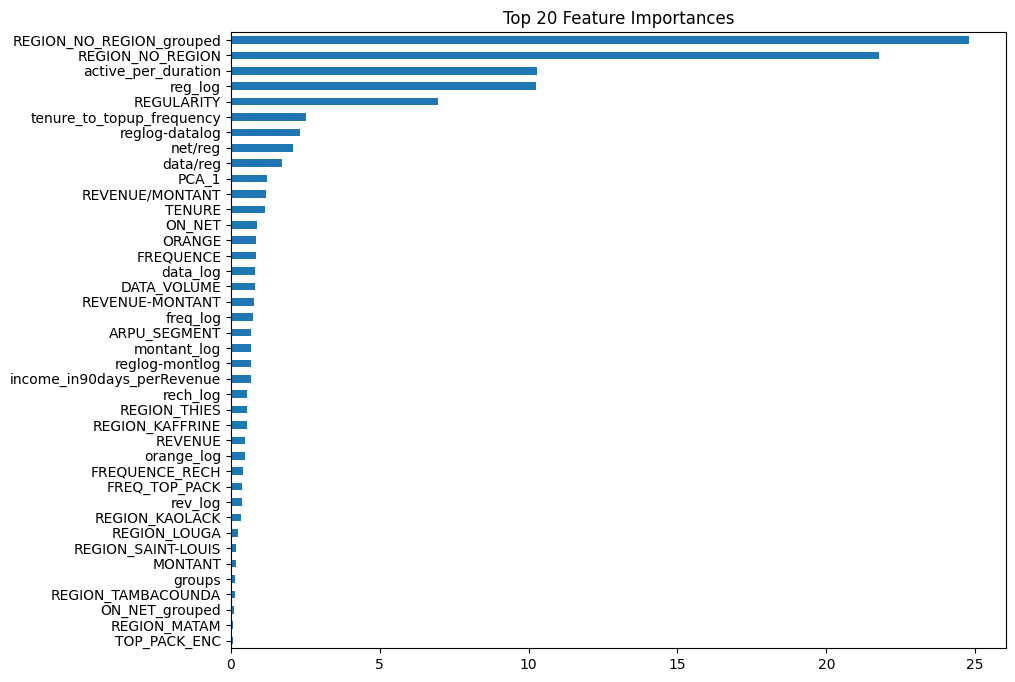

In [157]:
#=========================================Feature Importance from Catboost Algo=========================================#

# Get the feature importances from the classifier
feature_importances = pd.Series(cbt_model.feature_importances_, index=X_train.columns)

# Sort the feature importances and select the top 20
top_30_features = feature_importances.sort_values(ascending=False).head(30)

# Plot the top 20 feature importances
top_30_features.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title('Top 30 Feature Importances')
plt.show()

In [ ]:
#=========================================Feature Importance from XGBoost Algo=========================================#

# Get the feature importances from the classifier
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# Sort the feature importances and select the top 20
top_30_features = feature_importances.sort_values(ascending=False).head(30)

# Plot the top 20 feature importances
top_30_features.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title('Top 30 Feature Importances')
plt.show()